In [100]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta 
import time
import requests
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn import svm

import keras
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow as tf

# Gather data, merging dataframes

In [4]:
## tweets dataframe
df_tweets = pd.DataFrame()

df_names = ['df_tweets_0_1000.csv',
            'df_tweets_1000_2000.csv',
            'df_tweets_2000_3000.csv',
            'df_tweets_3000_4000.csv',
            'df_tweets_4000_5000.csv',
            'df_tweets_6000_7000.csv',
            'df_tweets_5000_6000.csv',
            'df_tweets_7000_8000.csv',]

for name in df_names:
    df_tmp = pd.read_csv('csvs/' + name)
    print(len(df_tmp))
    df_tweets = df_tweets.append(df_tmp)

995
997
1000
1000
1000
1000
1000
275


In [5]:
df_tweets.head()

,color,precipIntensity,precipProbability,summary,temperature,timestamp,visibility,windSpeed
0,yellow,0.0,0.0,Partly Cloudy,47.62,2009-11-15 09:00:00,6.216,4.62
1,yellow,0.0,0.0,Partly Cloudy,50.06,2009-11-15 10:00:00,6.216,8.16
2,green,0.0,0.0,Partly Cloudy,52.58,2009-11-15 11:00:00,6.216,10.14
3,green,0.0,0.0,Partly Cloudy,54.09,2009-11-15 12:00:00,6.216,10.22
4,green,0.0,0.0,Partly Cloudy,55.15,2009-11-15 13:00:00,6.216,10.80


In [6]:
len(df_tweets)

7267

In [7]:
df_tweets_edit = df_tweets.copy()
df_tweets_edit.drop('visibility',axis=1,inplace=True)
df_tweets_edit.drop('summary',axis=1,inplace=True)
df_tweets_edit.drop('timestamp',axis=1,inplace=True)

In [8]:
df_tweets_edit.head()

,color,precipIntensity,precipProbability,temperature,windSpeed
0,yellow,0.0,0.0,47.62,4.62
1,yellow,0.0,0.0,50.06,8.16
2,green,0.0,0.0,52.58,10.14
3,green,0.0,0.0,54.09,10.22
4,green,0.0,0.0,55.15,10.80


In [9]:
df_tweets_edit['color'].unique()

array(['yellow', 'green', 'red'], dtype=object)

In [10]:
label_list = [0 if c == 'green' else 1 for c in df_tweets_edit['color']]
df_tweets_edit['label'] = label_list
df_tweets_final = df_tweets_edit.copy()
df_tweets_final.drop('color',axis=1,inplace=True)

In [11]:
df_tweets_final.head()

,precipIntensity,precipProbability,temperature,windSpeed,label
0,0.0,0.0,47.62,4.62,1
1,0.0,0.0,50.06,8.16,1
2,0.0,0.0,52.58,10.14,0
3,0.0,0.0,54.09,10.22,0
4,0.0,0.0,55.15,10.80,0


In [12]:
# df from data_generator.py
df_data_gen = pd.read_csv('csvs/df.csv',index_col=0)
df_data_gen.head()

,precipIntensity,precipProbability,temperature,windSpeed,label
0,0.0,0.0,41.24,22.44,1
1,0.0,0.0,41.28,26.34,1
2,0.0,0.0,41.14,22.56,1
3,0.0,0.0,42.95,23.52,1
4,0.0,0.0,42.91,23.65,1


In [13]:
# merge dataframes
df = pd.merge(df_data_gen,df_tweets_final,how='outer')
df.head()

,precipIntensity,precipProbability,temperature,windSpeed,label
0,0.0,0.0,41.24,22.44,1
1,0.0,0.0,41.28,26.34,1
2,0.0,0.0,41.14,22.56,1
3,0.0,0.0,42.95,23.52,1
4,0.0,0.0,42.91,23.65,1


In [12]:
## save merged df
df.to_csv('csvs/merged_df.csv')

# Data Visualization

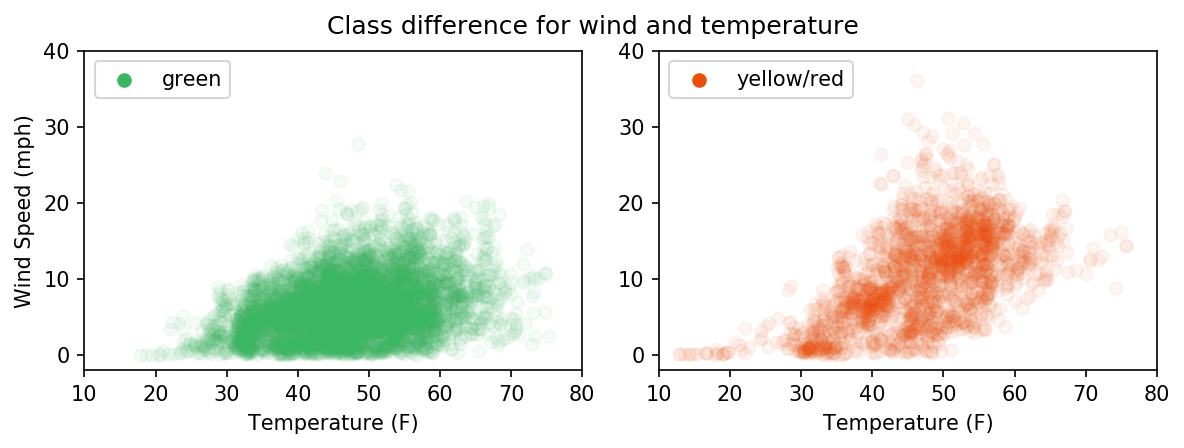

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), dpi=150)

green, red = '#3bb662','#ea4e0b'

x = df.where(df['label']==0)['temperature']
y = df.where(df['label']==0)['windSpeed']

ax[0].scatter(x,y,alpha=.05, c=green, label = 'green')
ylim = ax[0].set_ylim([-2,40])
xlim = ax[0].set_xlim([10,80])

ylabel = ax[0].set_ylabel('Wind Speed (mph)')
xlabel = ax[0].set_xlabel('Temperature (F)')
legend = ax[0].legend(loc=2)

for lh in legend.legendHandles: 
    lh.set_alpha(1)

x = df.where(df['label']==1)['temperature']
y = df.where(df['label']==1)['windSpeed']

ax[1].scatter(x,y,alpha=.05, c=red, label = 'yellow/red')
#ax.legend()

#title = ax[0].set_title(name,fontsize=10)
ylim = ax[1].set_ylim([-2,40])
xlim = ax[1].set_xlim([10,80])
#ylabel = ax[0].set_ylabel('Wind Speed (mph)')
xlabel = ax[1].set_xlabel('Temperature (F)')
legend = ax[1].legend(loc=2)

for lh in legend.legendHandles: 
    lh.set_alpha(1)
    
title = fig.suptitle('Class difference for wind and temperature', fontsize=12)
plt.tight_layout()

top = 0.9
plt.subplots_adjust(left=None, bottom=None, right=None, top=top, wspace=None, hspace=None)

#plt.savefig('figs/data_viz.png',dpi=300,pad_inches=0)

# Model fitting and selection

In [42]:
# make train/test
x = df.drop('label',axis=1)
y = df['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33) #, random_state=2)

### Dealing with class imbalance

In [15]:
weight_list = np.arange(1,3.75,.25)
metrics_list = []
for weight in weight_list:
    model = svm.SVC(kernel='linear', class_weight={1: weight}, probability=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    acc = metrics.accuracy_score(y_test,y_pred)
    recall = metrics.recall_score(y_test,y_pred)
    precision = metrics.precision_score(y_test,y_pred)
    
    cm = metrics.confusion_matrix(y_test,y_pred)
    tn = cm[0,0]
    fn = cm[1,0]
    tp = cm[1,1]
    fp = cm[0,1]
    sens = tp / (tp + fn)
    spec = tn / (fp + tn)

    metrics_list.append([acc,recall,precision,sens,spec])

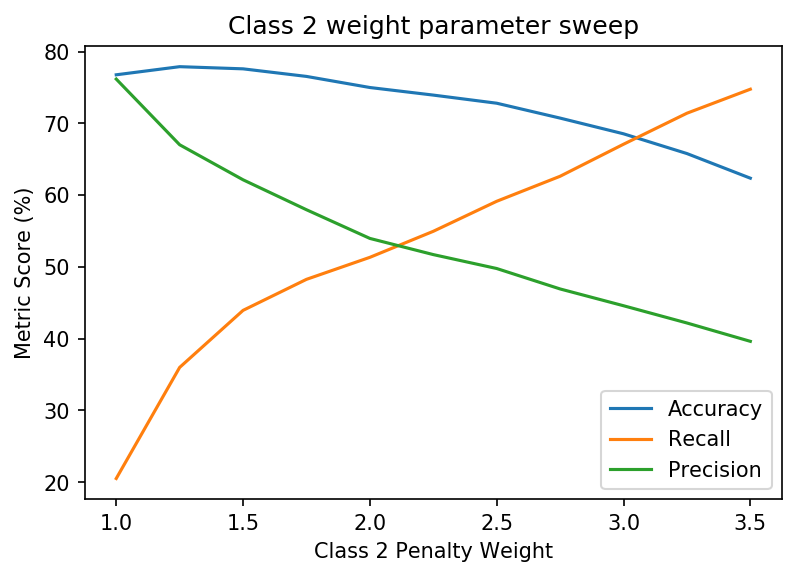

In [16]:
metrics_array = np.array(metrics_list)
acc = metrics_array[:,0]*100
recall = metrics_array[:,1]*100
precision = metrics_array[:,2]*100

fig1 = plt.figure(figsize=(6,4),dpi=150)
ax = plt.gca()

acc_plot = ax.plot(weight_list, acc, label='Accuracy')
recall_plot = ax.plot(weight_list, recall, label='Recall')
precision_plot = ax.plot(weight_list, precision, label='Precision')

legend = ax.legend(loc=4)
title = ax.set_title('Class 2 weight parameter sweep')
ylabel = ax.set_ylabel('Metric Score (%)')
xlabel = ax.set_xlabel('Class 2 Penalty Weight')

#plt.savefig('figs/param_sweep.png',dpi=150)

### Training sklearn models

In [17]:
svm_linear = svm.SVC(kernel='linear', class_weight={1: 2}, probability=True)
svm_rbf_1 = svm.SVC(kernel='rbf', class_weight={1: 2}, probability=True, gamma=.01)
svm_rbf_2 = svm.SVC(kernel='rbf', class_weight={1: 2}, probability=True, gamma=.005)

model = svm_linear

In [18]:
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [19]:
acc = metrics.accuracy_score(y_test,y_pred)
print(f'accuracy = {acc}')

recall = metrics.recall_score(y_test,y_pred)
print(f'recall = {recall}')

precision = metrics.precision_score(y_test,y_pred)
print(f'precision = {precision}')

accuracy = 0.7499056959637872
recall = 0.5132496513249651
precision = 0.5395894428152492


In [20]:
print(f'{y_pred.sum()} class 1 prediction compared to {y_test.sum()} in the test set out of {len(y_test)} total')

682 class 1 prediction compared to 717 in the test set out of 2651 total


### Making single prediction

In [21]:
def get_prediction(x_list):
    x_to_pred = np.array(x_list).reshape(-1,4)
    return model.predict_proba(x_to_pred)[0]

In [22]:
precipIntensity = 0
precipProbability = 0
temperature = 34
windSpeed = 5
x_to_pred = np.array([precipIntensity,precipProbability,temperature,windSpeed])
p_0, p_1 = get_prediction(x_to_pred)

print(f'Predicts a {round(p_1*100,1)} percent change of yellow/red flag')

Predicts a 24.3 percent change of yellow/red flag


### Plotting decision boundary

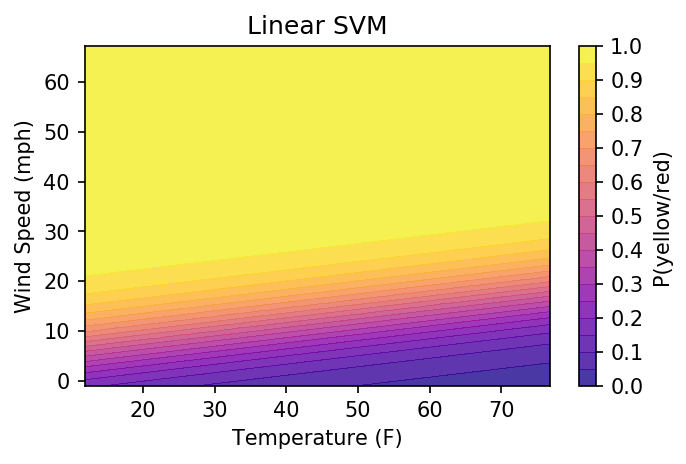

In [23]:
# Plotting decision regions
# x is temperature
# y is windSpeed
# precipProbability and precipProbability held constant at 0
model_name = 'Linear SVM'

resolution = 100
x_min, x_max = x['temperature'].min() - 1, x['temperature'].max() + 1
y_min, y_max = x['windSpeed'].min() - 1, x['windSpeed'].max() + 1

const_1 = np.arange(0, .01, 0.1)
const_2 = np.arange(0, .01, 0.1)
xx = np.linspace(x_min, x_max, resolution)
yy = np.linspace(y_min, y_max, resolution)
C1, C2, YY, XX = np.meshgrid(const_1, const_2, yy, xx)
xy = np.vstack([C1.ravel(), C2.ravel(), XX.ravel(), YY.ravel()]).T

z = model.predict_proba(xy)[:,1].reshape(resolution,resolution)

fig1 = plt.figure(figsize=(5,3),dpi=150)
ax = plt.gca()
levels, ticks = np.linspace(0,1,21), np.linspace(0,1,11)
cs = ax.contourf(xx, yy, z, alpha=.8, levels = levels, cmap=plt.cm.plasma, vmin=0, vmax=1, extend='neither')

fig1 = plt.gcf()
cb = fig1.colorbar(cs,ticks=ticks,label='P(yellow/red)')

title = ax.set_title(model_name)
ylabel = ax.set_ylabel('Wind Speed (mph)')
xlabel = ax.set_xlabel('Temperature (F)')

### Training neural net using Keras

In [157]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

In [158]:
y_train_binary = to_categorical(y_train)
y_test_binary = to_categorical(y_test)

In [159]:
nn_model = Sequential()
nn_model.add(Dense(100, input_shape=(4,),activation='relu'))
nn_model.add(Dropout(.25, noise_shape=None, seed=None))
nn_model.add(Dense(100,activation='relu'))
nn_model.add(Dropout(.25, noise_shape=None, seed=None))
nn_model.add(Dense(2,activation='softmax'))
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 100)               500       
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_11 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 202       
Total params: 10,802
Trainable params: 10,802
Non-trainable params: 0
_________________________________________________________________


In [160]:
nn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [161]:
class_weight = {0: 1,1: 2}

history = nn_model.fit(x_train, y_train_binary, epochs=100, batch_size=100,  verbose=0,
                    validation_split=0.1,
                    class_weight=class_weight)

In [162]:
y_pred = nn_model.predict(x_test)
y_pred_classes = nn_model.predict_classes(x_test)

In [163]:
y_pred_classes.sum()

658

In [164]:
y_test.sum()

702

In [165]:
scores = nn_model.evaluate(x, to_categorical(y), verbose=0)
for score in [0,1]:
    print("%s: %.2f%%" % (nn_model.metrics_names[score], scores[score]*100))

loss: 54.19%
acc: 75.40%


In [183]:
acc = metrics.accuracy_score(y_test,y_pred_classes)
print(f'accuracy = {acc}')

recall = metrics.recall_score(y_test,y_pred_classes)
print(f'recall = {recall}')

precision = metrics.precision_score(y_test,y_pred_classes)
print(f'precision = {precision}')

accuracy = 0.7600905318747643
recall = 0.5156695156695157
precision = 0.5501519756838906


In [166]:
nn_model.save('model_keras')

tf_model = tf.keras.models.load_model('model_keras')
tf_model.save('model.h5')

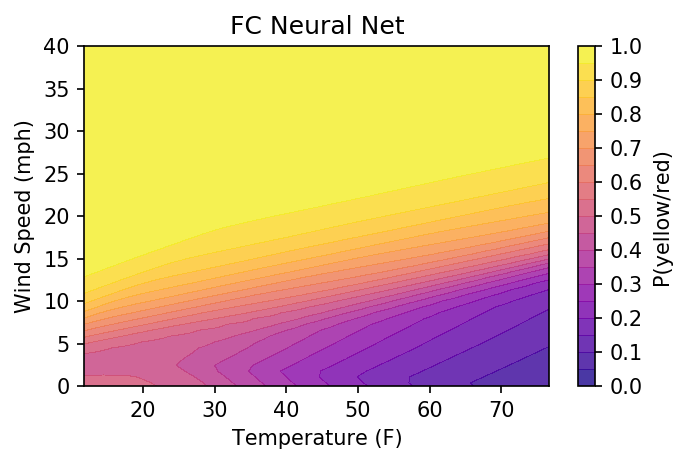

In [167]:
model_name = 'FC Neural Net'
resolution = 100
x_min, x_max = x['temperature'].min() - 1, x['temperature'].max() + 1
y_min, y_max = x['windSpeed'].min() - 1, x['windSpeed'].max() + 1

const_1 = np.arange(0, 0.01, 0.1)
const_2 = np.arange(0, 0.01, 0.1)
xx = np.linspace(x_min, x_max, resolution)
yy = np.linspace(y_min, y_max, resolution)
C1, C2, YY, XX = np.meshgrid(const_1, const_2, yy, xx)
xy = np.vstack([C1.ravel(), C2.ravel(), XX.ravel(), YY.ravel()]).T

z = nn_model.predict(xy)[:,1].reshape(resolution,resolution)

fig1 = plt.figure(figsize=(5,3),dpi=150)
ax = plt.gca()
levels, ticks = np.linspace(0,1,21), np.linspace(0,1,11)
cs = ax.contourf(xx, yy, z, alpha=.8, levels = levels, cmap=plt.cm.plasma, vmin=0, vmax=1, extend='neither')

fig1 = plt.gcf()
cb = fig1.colorbar(cs,ticks=ticks,label='P(yellow/red)')

title = ax.set_title(model_name)
ylabel = ax.set_ylabel('Wind Speed (mph)')
xlabel = ax.set_xlabel('Temperature (F)')
ylim = ax.set_ylim([0,40])


# Comparing models

In [168]:
def make_plot(fig,ax,this_model,name):
    this_model.fit(x_train, y_train)
    y_pred = this_model.predict(x_test)
    
    resolution = 100
    x_min, x_max = x['temperature'].min() - 1, x['temperature'].max() + 1
    y_min, y_max = x['windSpeed'].min() - 1, x['windSpeed'].max() + 1

    const_1 = np.arange(0, .01, 0.1)
    const_2 = np.arange(0, .01, 0.1)
    xx = np.linspace(x_min, x_max, resolution)
    yy = np.linspace(y_min, y_max, resolution)
    C1, C2, YY, XX = np.meshgrid(const_1, const_2, yy, xx)
    xy = np.vstack([C1.ravel(), C2.ravel(), XX.ravel(), YY.ravel()]).T

    z = this_model.predict_proba(xy)[:,1].reshape(resolution,resolution)

    levels, ticks = np.linspace(0,1,21), np.linspace(0,1,11)
    cont = ax.contourf(xx, yy, z, alpha=.8, levels = levels, cmap=plt.cm.plasma, vmin=0, vmax=1, extend='neither')
    cb = fig.colorbar(cont, ax=ax, ticks=ticks, label='P(yellow/red)')

    title = ax.set_title(name,fontsize=10)
    ylabel = ax.set_ylabel('Wind Speed (mph)')
    xlabel = ax.set_xlabel('Temperature (F)')
    ylim = ax.set_ylim([0,40])
    
    return fig

In [169]:
def make_plot_nn(fig,ax,name):
    y_pred = nn_model.predict(x_test)
    
    resolution = 100
    x_min, x_max = x['temperature'].min() - 1, x['temperature'].max() + 1
    y_min, y_max = x['windSpeed'].min() - 1, x['windSpeed'].max() + 1

    const_1 = np.arange(0, .01, 0.1)
    const_2 = np.arange(0, .01, 0.1)
    xx = np.linspace(x_min, x_max, resolution)
    yy = np.linspace(y_min, y_max, resolution)
    C1, C2, YY, XX = np.meshgrid(const_1, const_2, yy, xx)
    xy = np.vstack([C1.ravel(), C2.ravel(), XX.ravel(), YY.ravel()]).T

    z = nn_model.predict(xy)[:,1].reshape(resolution,resolution)
    
    levels, ticks = np.linspace(0,1,21), np.linspace(0,1,11)
    cont = ax.contourf(xx, yy, z, alpha=.8, levels = levels, cmap=plt.cm.plasma, vmin=0, vmax=1, extend='neither')
    
    cb = fig.colorbar(cont, ax=ax, ticks=ticks, label='P(yellow/red)')

    title = ax.set_title(name,fontsize=10)
    ylabel = ax.set_ylabel('Wind Speed (mph)')
    xlabel = ax.set_xlabel('Temperature (F)')
    ylim = ax.set_ylim([0,40])
        
    return fig

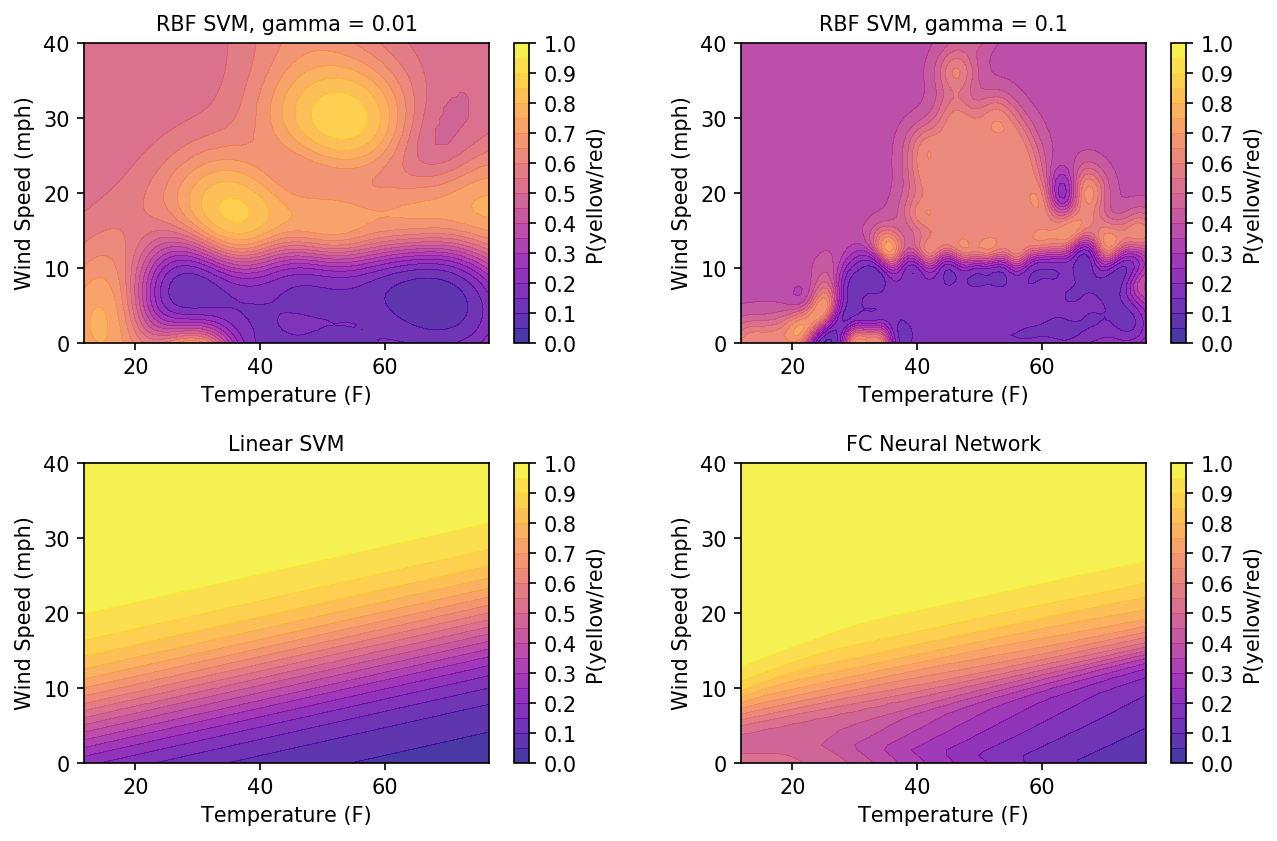

In [201]:

#plt.close(axes)

fig, axes = plt.subplots(2, 2, figsize=(10, 6), dpi=150)

w_2_svm_rbf_gamma_0_01 = svm.SVC(kernel='rbf', class_weight={1: 2}, probability=True, gamma=.01)
fig = make_plot(fig,axes[0,0],w_2_svm_rbf_gamma_0_01,'RBF SVM, gamma = 0.01')

w_2_svm_rbf_gamma_0_1 = svm.SVC(kernel='rbf', class_weight={1: 2}, probability=True, gamma=.1)
fig = make_plot(fig,axes[0,1],w_2_svm_rbf_gamma_0_1,'RBF SVM, gamma = 0.1')

w_2_svm = svm.SVC(kernel='linear', class_weight={1: 2}, probability=True)
fig = make_plot(fig,axes[1,0],w_2_svm,'Linear SVM')

fig = make_plot_nn(fig,axes[1,1],'FC Neural Network')


left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.3   # the amount of width reserved for blank space between subplots
hspace = 0.4   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

#plt.tight_layout()
fig.savefig('figs/model_comparison_2.png',dpi=300,pad_inches=0)

plt.show()
